In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import re

In [2]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from nltk.stem import LancasterStemmer, SnowballStemmer, RegexpStemmer, WordNetLemmatizer
from nltk.tag import pos_tag
import nltk

from textblob import TextBlob
from textblob import Word

from afinn import Afinn

import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
from spacy import displacy

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix

In [3]:
df = pd.read_csv('modeling_3.csv',  index_col='Unnamed: 0')

In [4]:
# Set Review Date to Datetime
df['review_date'] = pd.to_datetime(df['review_date'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 615 entries, 0 to 614
Data columns (total 63 columns):
name              615 non-null object
rating            615 non-null object
review_date       615 non-null datetime64[ns]
reviewer          615 non-null object
review_url        615 non-null object
neighborhood      614 non-null object
review            615 non-null object
headline          615 non-null object
tokens            615 non-null object
vocabulary        615 non-null int64
area              615 non-null object
af_avg_pol        615 non-null float64
af_min_pol        615 non-null float64
af_max_pol        615 non-null float64
af_std_pol        615 non-null float64
triumphant        615 non-null float64
win               615 non-null float64
hell              615 non-null float64
masterpiece       615 non-null float64
thrilled          615 non-null float64
wonderful         615 non-null float64
damned            615 non-null float64
breathtaking      615 non-null float64
he

In [6]:
df.head()

name rating review_date    reviewer  \
0              Hanon     ★★  2019-05-21  Pete Wells   
1          Del Posto    ★★★  2019-05-14  Pete Wells   
2  The Freakin Rican      ★  2019-05-07  Pete Wells   
3              Wayan     ★★  2019-04-23  Pete Wells   
4              Niche      ★  2019-04-16  Pete Wells   

                                          review_url     neighborhood  \
0  https://www.nytimes.com/2019/05/21/dining/hano...     Williamsburg   
1  https://www.nytimes.com/2019/05/14/dining/del-...          Chelsea   
2  https://www.nytimes.com/2019/05/07/dining/the-...          Astoria   
3  https://www.nytimes.com/2019/04/23/dining/waya...           NoLIta   
4  https://www.nytimes.com/2019/04/16/dining/nich...  Lower East Side   

                                              review  \
0  Hanon, a new udon shop in Williamsburg, Brookl...   
1  More than a year ago, I was on the verge of re...   
2  It is true that the bacalaitos at the Freakin ...   
3  If you ate at Spice Market before it closed tw...   
4  In 2012 and 2013, when people were lining up a...   

                                            headline  \
0                  Udon, Innovated for Your Pleasure   
1  In Del Posto’s New Era, Cuisine and Service Ar...   
2  Pasteles and Two Kinds of Fried Chicken at the...   
3     Tapping a Family Connection to Indonesian Food   
4  Ramen Without Broth? A Chef Doubles Down on a ...   

                                              tokens  vocabulary  ... bastard  \
0  ['hanon', 'udon', 'williamsburg', 'brooklyn', ...         416  ...     0.0   
1  ['ago', 'verge', 'reviewing', 'del', 'posto', ...         606  ...     0.0   
2  ['true', 'bacalaitos', 'freakin', 'rican', 'as...         471  ...     0.0   
3  ['spice', 'market', 'closed', 'year', 'ago', '...         425  ...     0.0   
4  ['people', 'lining', 'smorgasburg', 'houston',...         414  ...     0.0   

   rapturous  x0_Frank Bruni  x0_Pete Wells  x0_Sam Sifton  x0_Brooklyn  \
0        0.0             0.0            1.0            0.0          1.0   
1        0.0             0.0            1.0            0.0          0.0   
2        0.0             0.0            1.0            0.0          0.0   
3        0.0             0.0            1.0            0.0          0.0   
4        0.0             0.0            1.0            0.0          0.0   

   x0_Downtown  x0_Midtown  x0_Other  x0_Uptown  
0          0.0         0.0       0.0        0.0  
1          0.0         1.0       0.0        0.0  
2          0.0         0.0       1.0        0.0  
3          1.0         0.0       0.0        0.0  
4          1.0         0.0       0.0        0.0  

[5 rows x 63 columns]

In [7]:
df.columns

Index(['name', 'rating', 'review_date', 'reviewer', 'review_url',
       'neighborhood', 'review', 'headline', 'tokens', 'vocabulary', 'area',
       'af_avg_pol', 'af_min_pol', 'af_max_pol', 'af_std_pol', 'triumphant',
       'win', 'hell', 'masterpiece', 'thrilled', 'wonderful', 'damned',
       'breathtaking', 'heavenly', 'wonderfully', 'terrifically', 'rejoice',
       'miracle', 'godsend', 'fabulous', 'torture', 'wow', 'ecstatic', 'slut',
       'brilliant', 'outstanding', 'amazing', 'supreme', 'tortured', 'triumph',
       'awesome', 'fraud', 'prick', 'funny', 'superb', 'fantastic',
       'exuberant', 'catastrophic', 'stunning', 'terrific', 'fun', 'funnier',
       'winning', 'bastard', 'rapturous', 'x0_Frank Bruni', 'x0_Pete Wells',
       'x0_Sam Sifton', 'x0_Brooklyn', 'x0_Downtown', 'x0_Midtown', 'x0_Other',
       'x0_Uptown'],
      dtype='object')

In [8]:
def add_num_rating(rating):
    
    if rating == '0 star':
        return 0
    elif rating == '★':
        return 1
    elif rating == '★★':
        return 2
    else:
        return 3
    
df['num_rating'] = df['rating'].apply(lambda x: add_num_rating(x))

In [9]:
df['num_rating'].describe()

count    615.000000
mean       1.606504
std        0.799811
min        0.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        3.000000
Name: num_rating, dtype: float64

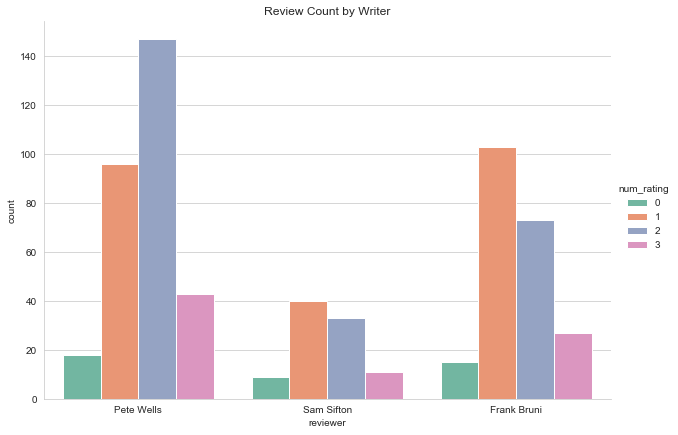

In [10]:
sns.set_style('whitegrid')
sns.catplot(x='reviewer',
            hue='num_rating',
            data=df,
            kind='count',
            height=6, 
            aspect=11.7/8.27,
            palette='Set2')

plt.title('Review Count by Writer');

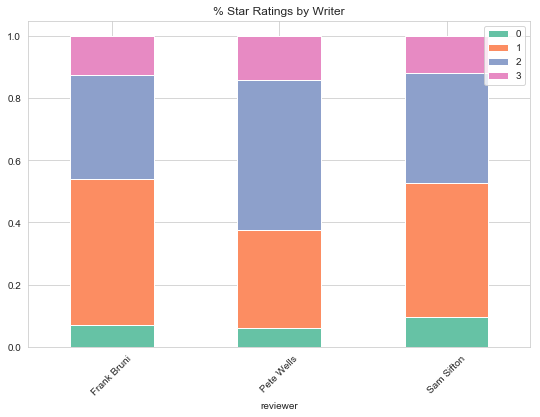

In [11]:
sns.set_palette('Set2')
x = df.groupby('reviewer')['num_rating'].value_counts(normalize=True).unstack()
x.plot(kind='bar', stacked='True', figsize=(9,6))
plt.legend(loc=1)
plt.xticks(rotation=45)
plt.title('% Star Ratings by Writer');
plt.show();

<Figure size 576x576 with 0 Axes>

Text(0.5, 1.0, 'Star Rating Violin Plots')

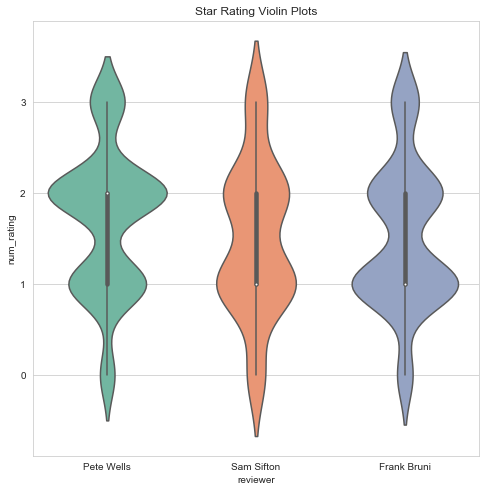

In [12]:
sns.set_palette('Set2')
plt.figure(figsize=(8,8))
sns.violinplot(x='reviewer',
               y='num_rating',
               data=df,
               kind='count')

plt.title('Star Rating Violin Plots')

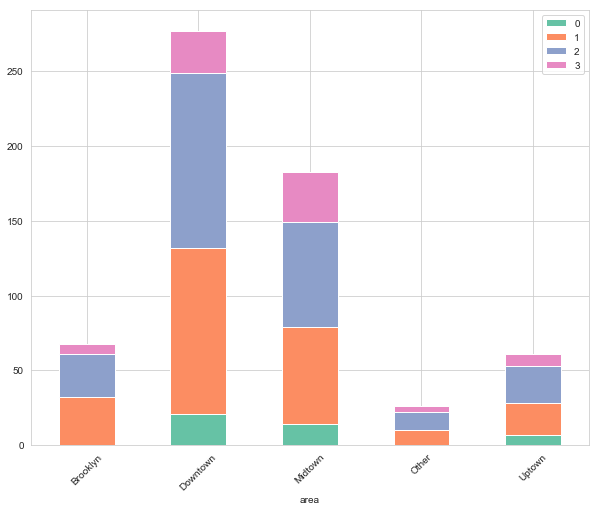

In [13]:
sns.set_palette('Set2')
x = df.groupby('area')['num_rating'].value_counts().unstack()
x.plot(kind='bar', stacked='True', figsize=(10,8))
plt.legend(loc=1)
plt.xticks(rotation=45)
plt.show();

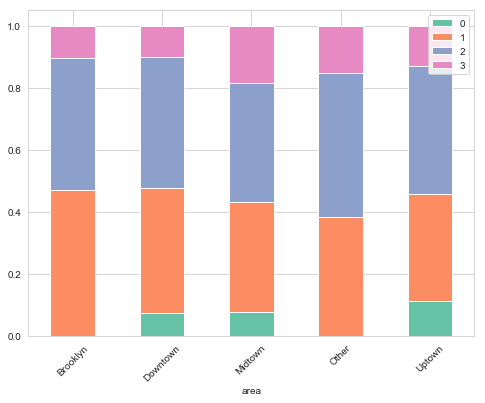

In [14]:
sns.set_palette('Set2')
x = df.groupby('area')['num_rating'].value_counts(normalize=True).unstack()
x.plot(kind='bar', stacked='True', figsize=(8,6))
plt.legend(loc=1)
plt.xticks(rotation=45)
plt.show();

In [15]:
df.groupby('reviewer')['review_date'].min()

reviewer
Frank Bruni   2004-06-16
Pete Wells    2009-09-15
Sam Sifton    2009-10-13
Name: review_date, dtype: datetime64[ns]

In [16]:
df.groupby(['reviewer'])['num_rating'].agg(['count', 'mean', 'std', 'min', 'max'])

count      mean       std  min  max
reviewer                                        
Frank Bruni    218  1.513761  0.798786    0    3
Pete Wells     304  1.707237  0.781266    0    3
Sam Sifton      93  1.494624  0.829139    0    3

## Headline Sentiment ( TextBlob)

In [17]:
def headline_sent(headline):

    zen = TextBlob(headline)
    return zen.sentiment[0]

df['headline_sentiment'] = df['headline'].apply(lambda x: headline_sent(x))

In [18]:
df.groupby('rating')['headline_sentiment'].describe()

count      mean       std       min  25%  50%       75%   max
rating                                                               
0 star   42.0  0.000433  0.058217 -0.200000  0.0  0.0  0.000000  0.25
★       239.0  0.025093  0.155222 -0.600000  0.0  0.0  0.000000  1.00
★★      253.0  0.016630  0.142970 -0.625000  0.0  0.0  0.000000  0.80
★★★      81.0  0.091809  0.201070 -0.416667  0.0  0.0  0.136364  0.80

In [19]:
def blob_polarity(review):
    
    polarity = []
    
    for sentence in TextBlob(review).sentences:
        polarity.append(sentence.sentiment[0])
    
    avg_pol = np.mean(polarity)
    min_pol = np.min(polarity)
    max_pol = np.max(polarity)
    std_pol = np.std(polarity)
    
    return avg_pol, min_pol, max_pol, std_pol

def add_blob_pol(df):
    
    df['blob_avg_pol'] = df['review'].apply(lambda x: blob_polarity(x)[0])
    df['blob_min_pol'] = df['review'].apply(lambda x: blob_polarity(x)[1])
    df['blob_max_pol'] = df['review'].apply(lambda x: blob_polarity(x)[2])
    df['blob_std_pol'] = df['review'].apply(lambda x: blob_polarity(x)[3])
    
    df['high_sentiment'] = np.where(df['blob_avg_pol'] > 0.05, 1, 0)
        
    return df

df = add_blob_pol(df)

In [20]:
dfx = df.set_index(df['review_date'])

In [21]:
dfx['year'] = dfx['review_date'].dt.year

In [22]:
df.iloc[0]['tokens']

"['hanon', 'udon', 'williamsburg', 'brooklyn', 'produced', 'union', 'tokyo', 'videoproduction', 'company', 'japanese', 'manufacturer', 'unusually', 'thin', 'condom', 'condom', 'became', 'subject', 'series', 'advertisement', 'production', 'company', 'worked', 'called', '“acts', 'love”', 'dancer', 'london', 'reenact', 'surprising', 'grace', 'dignity', 'mating', 'ritual', 'bluefooted', 'booby', 'fiddler', 'crab', 'animal', 'well', 'kid', 'company', 'like', 'much', 'sometimes', 'decide', 'create', 'company', 'together', 'happened', 'production', 'firm', 'prophylactic', 'people', 'reason', 'perhaps', 'best', 'question', 'hit', 'upon', 'idea', 'expanding', 'product', 'line', 'condom', 'noodle', 'lie', 'across', 'union', 'avenue', 'kellogg’s', 'diner', 'door', 'marked', 'business', 'fluttering', 'white', 'noren', 'curtain', 'hanon', 'location', '6700', 'mile', 'away', 'city', 'kamakura', 'lie', 'south', 'tokyo', 'known', 'soba', 'udon', 'gave', 'hanon', 'advantage', 'competing', 'japan’s', 'e

In [23]:
pop_word_by_year = {}

for year in dfx['year']:
    
    pop_word_dict = {}
    pop_word_by_year[year] = pop_word_by_year.get(year, pop_word_dict)
    
    for word_list in dfx[dfx['year'] == year]['tokens']:
        
        for word in word_list:
            

SyntaxError: unexpected EOF while parsing (<ipython-input-23-f7f6a78be0d5>, line 11)

In [22]:
pop_word_by_year

{2019: {"['hanon', 'udon', 'williamsburg', 'brooklyn', 'produced', 'union', 'tokyo', 'videoproduction', 'company', 'japanese', 'manufacturer', 'unusually', 'thin', 'condom', 'condom', 'became', 'subject', 'series', 'advertisement', 'production', 'company', 'worked', 'called', '“acts', 'love”', 'dancer', 'london', 'reenact', 'surprising', 'grace', 'dignity', 'mating', 'ritual', 'bluefooted', 'booby', 'fiddler', 'crab', 'animal', 'well', 'kid', 'company', 'like', 'much', 'sometimes', 'decide', 'create', 'company', 'together', 'happened', 'production', 'firm', 'prophylactic', 'people', 'reason', 'perhaps', 'best', 'question', 'hit', 'upon', 'idea', 'expanding', 'product', 'line', 'condom', 'noodle', 'lie', 'across', 'union', 'avenue', 'kellogg’s', 'diner', 'door', 'marked', 'business', 'fluttering', 'white', 'noren', 'curtain', 'hanon', 'location', '6700', 'mile', 'away', 'city', 'kamakura', 'lie', 'south', 'tokyo', 'known', 'soba', 'udon', 'gave', 'hanon', 'advantage', 'competing', 'japa

In [24]:
df.groupby(['reviewer', 'num_rating'])['blob_avg_pol'].agg(['mean', 'std', 'min', 'max'])

mean       std       min       max
reviewer    num_rating                                        
Frank Bruni 0           0.051286  0.024985  0.010512  0.099112
            1           0.093595  0.036144  0.012608  0.203953
            2           0.100241  0.032090  0.009941  0.182138
            3           0.113063  0.028226  0.056232  0.182825
Pete Wells  0           0.061155  0.035863 -0.032365  0.106247
            1           0.099230  0.038995 -0.008443  0.187039
            2           0.100276  0.039596  0.011658  0.190378
            3           0.111014  0.039063 -0.011801  0.185003
Sam Sifton  0           0.095488  0.035607  0.047251  0.161116
            1           0.117410  0.041884  0.035948  0.237817
            2           0.115307  0.042815  0.016241  0.185077
            3           0.091549  0.029373  0.025646  0.127068

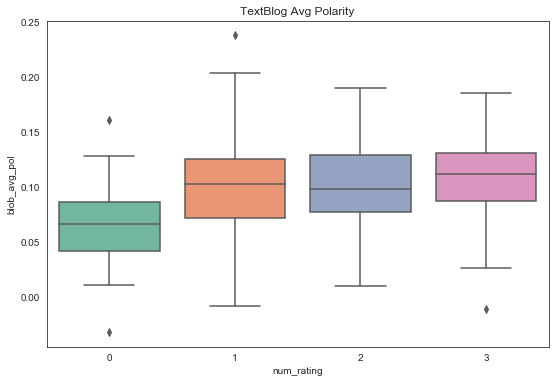

In [25]:
sns.set_style('white')
plt.figure(figsize=(9,6))
ax = sns.boxplot(x='num_rating', 
                   y='blob_avg_pol', 
                   data=df, 
                   palette="Set2", 
                   dodge=True)

plt.title('TextBlog Avg Polarity')
ax;

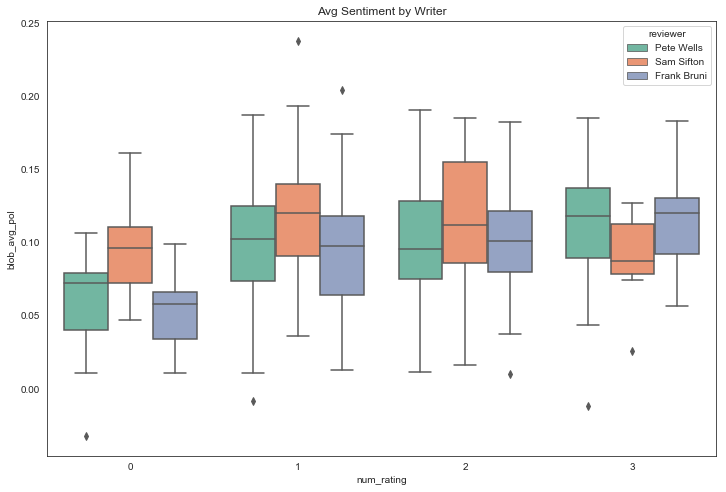

In [26]:
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='num_rating', 
                 y='blob_avg_pol',
                 hue='reviewer',
                 data=df, 
                 palette="Set2", 
                 dodge=True)

plt.title('Avg Sentiment by Writer')
ax;

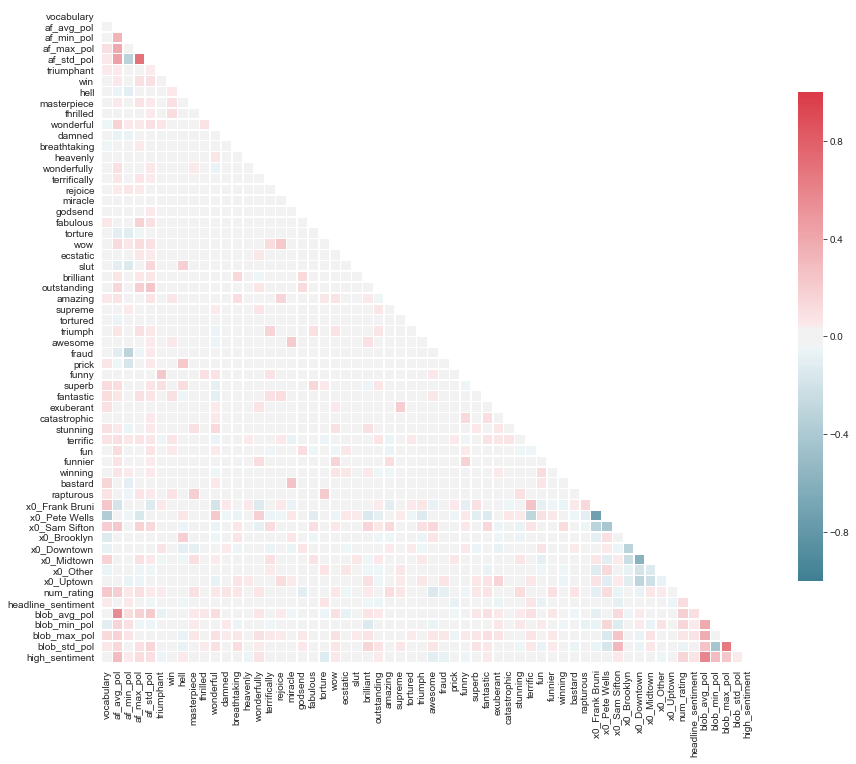

In [27]:
corr = df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .75});

In [28]:
dfx = df.copy(deep=True)

In [29]:
dfx.columns

Index(['name', 'rating', 'review_date', 'reviewer', 'review_url',
       'neighborhood', 'review', 'headline', 'tokens', 'vocabulary', 'area',
       'af_avg_pol', 'af_min_pol', 'af_max_pol', 'af_std_pol', 'triumphant',
       'win', 'hell', 'masterpiece', 'thrilled', 'wonderful', 'damned',
       'breathtaking', 'heavenly', 'wonderfully', 'terrifically', 'rejoice',
       'miracle', 'godsend', 'fabulous', 'torture', 'wow', 'ecstatic', 'slut',
       'brilliant', 'outstanding', 'amazing', 'supreme', 'tortured', 'triumph',
       'awesome', 'fraud', 'prick', 'funny', 'superb', 'fantastic',
       'exuberant', 'catastrophic', 'stunning', 'terrific', 'fun', 'funnier',
       'winning', 'bastard', 'rapturous', 'x0_Frank Bruni', 'x0_Pete Wells',
       'x0_Sam Sifton', 'x0_Brooklyn', 'x0_Downtown', 'x0_Midtown', 'x0_Other',
       'x0_Uptown', 'num_rating', 'headline_sentiment', 'blob_avg_pol',
       'blob_min_pol', 'blob_max_pol', 'blob_std_pol', 'high_sentiment'],
      dtype='object')

In [30]:
# = ['af_avg_pol', 'af_std_pol', 'x0_Brooklyn', 'x0_Downtown','x0_Midtown', 'x0_Other', 'x0_Uptown', 'headline_sent', 'blob_min_pol', 'blob_max_pol']

In [31]:
dfx.drop(['name','review_date','review_url','neighborhood','review','tokens', 'af_std_pol',\
          'af_min_pol', 'af_max_pol','reviewer','headline','headline_sentiment', 'area','rating','blob_std_pol', \
          'blob_max_pol', 'blob_min_pol'], axis=1, inplace=True)

In [32]:
dfx.columns

Index(['vocabulary', 'af_avg_pol', 'triumphant', 'win', 'hell', 'masterpiece',
       'thrilled', 'wonderful', 'damned', 'breathtaking', 'heavenly',
       'wonderfully', 'terrifically', 'rejoice', 'miracle', 'godsend',
       'fabulous', 'torture', 'wow', 'ecstatic', 'slut', 'brilliant',
       'outstanding', 'amazing', 'supreme', 'tortured', 'triumph', 'awesome',
       'fraud', 'prick', 'funny', 'superb', 'fantastic', 'exuberant',
       'catastrophic', 'stunning', 'terrific', 'fun', 'funnier', 'winning',
       'bastard', 'rapturous', 'x0_Frank Bruni', 'x0_Pete Wells',
       'x0_Sam Sifton', 'x0_Brooklyn', 'x0_Downtown', 'x0_Midtown', 'x0_Other',
       'x0_Uptown', 'num_rating', 'blob_avg_pol', 'high_sentiment'],
      dtype='object')

In [33]:
# dfx = dfx[['vocabulary','x0_Frank Bruni', 'x0_Sam Sifton', 'x0_Brooklyn', \
#           'x0_Midtown', 'x0_Other', 'x0_Uptown', 'num_rating',\
#           'blob_avg_pol', 'blob_min_pol', 'blob_max_pol', 'blob_std_pol',\
#           'high_sentiment']]

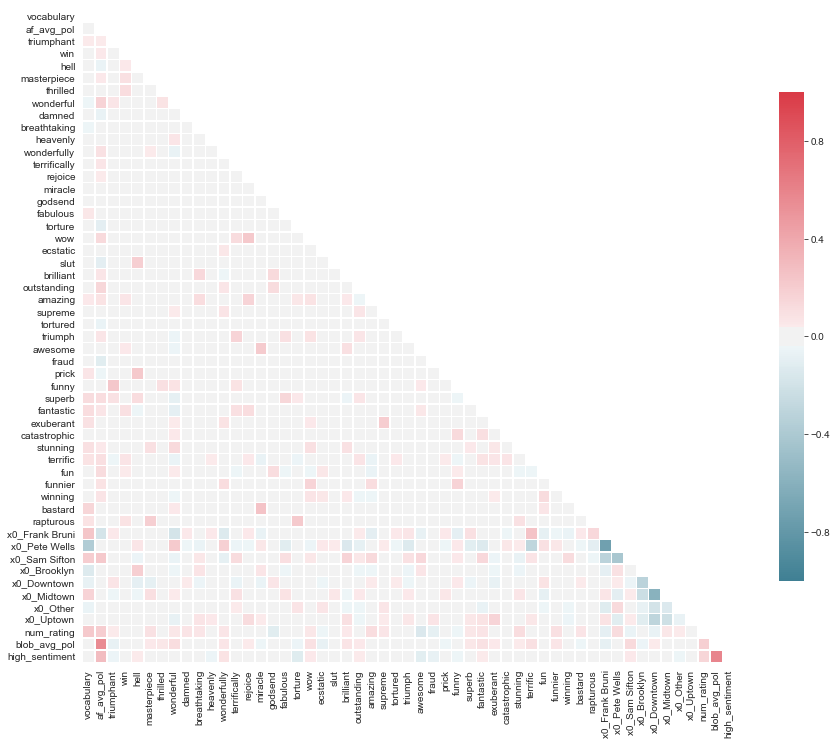

In [34]:
corr = dfx.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .75});

In [35]:
apply_interactions = True

def add_interactions(df):
    
    if apply_interactions:
        
        #Interactions with 'Rate'
        df['x0_Frank Bruni_X_blob_avg_pol'] = df['x0_Frank Bruni'] * df['blob_avg_pol']
        df['x0_Sam Sifton_X_blob_avg_pol'] = df['x0_Sam Sifton'] * df['blob_avg_pol']
        df['x0_Pete Wells_X_blob_avg_pol'] = df['x0_Pete Wells'] * df['blob_avg_pol']
        
        df['x0_Frank Bruni_X_vocab'] = df['x0_Frank Bruni'] * df['vocabulary']
        df['x0_Sam Sifton_X_vocab'] = df['x0_Sam Sifton'] * df['vocabulary']
        df['x0_Pete Wells_X_vocab'] = df['x0_Pete Wells'] * df['vocabulary']
    
        df['x0_Frank Bruni_X_sent'] = df['x0_Frank Bruni'] * df['high_sentiment']
        df['x0_Sam Sifton_X_sent'] = df['x0_Sam Sifton'] * df['high_sentiment']
        df['x0_Pete Wells_X_sent'] = df['x0_Pete Wells'] * df['high_sentiment']
        
        return df
    
    else:
        
        return df

df = add_interactions(dfx)

In [36]:
dfx.head()

vocabulary  af_avg_pol  triumphant  win  hell  masterpiece  thrilled  \
0         416    0.886364         0.0  0.0   0.0          0.0       0.0   
1         606    0.716216         0.0  0.0   0.0          0.0       0.0   
2         471    0.865385         0.0  0.0   0.0          0.0       0.0   
3         425    0.750000         0.0  0.0   0.0          0.0       0.0   
4         414    0.387755         0.0  0.0   0.0          0.0       0.0   

   wonderful  damned  breathtaking  ...  high_sentiment  \
0   0.000000     0.0           0.0  ...               0   
1   0.018381     0.0           0.0  ...               1   
2   0.000000     0.0           0.0  ...               1   
3   0.000000     0.0           0.0  ...               1   
4   0.000000     0.0           0.0  ...               1   

   x0_Frank Bruni_X_blob_avg_pol  x0_Sam Sifton_X_blob_avg_pol  \
0                            0.0                           0.0   
1                            0.0                           0.0   
2                            0.0                           0.0   
3                            0.0                           0.0   
4                            0.0                           0.0   

   x0_Pete Wells_X_blob_avg_pol  x0_Frank Bruni_X_vocab  \
0                      0.011658                     0.0   
1                      0.142618                     0.0   
2                      0.080008                     0.0   
3                      0.104236                     0.0   
4                      0.073833                     0.0   

   x0_Sam Sifton_X_vocab  x0_Pete Wells_X_vocab  x0_Frank Bruni_X_sent  \
0                    0.0                  416.0                    0.0   
1                    0.0                  606.0                    0.0   
2                    0.0                  471.0                    0.0   
3                    0.0                  425.0                    0.0   
4                    0.0                  414.0                    0.0   

   x0_Sam Sifton_X_sent  x0_Pete Wells_X_sent  
0                   0.0                   0.0  
1                   0.0                   1.0  
2                   0.0                   1.0  
3                   0.0                   1.0  
4                   0.0                   1.0  

[5 rows x 62 columns]

# Helper Functions

In [37]:
# Scorer Function that takes in Classifier as an argument with test data
def score_model(clf, X_train, X_test, y_train, y_test):
    
    print('Model Scores for: ', '\n\n','---->', clf, '\n')
    print('Train Accuracy score: ', accuracy_score(y_train, clf.predict(X_train)))
    print('Test Accuracy score: ', accuracy_score(y_test, clf.predict(X_test)),'\n')
    print('Classification Report: ', '\n', classification_report(y_test, clf.predict(X_test)), '\n')
    
    return clf

In [38]:
#Confusion Matrix Fuction
def confusion_func(clf, X_test, y_test):
    
    sns.set_style('whitegrid')
    plt.figure(figsize = (9, 9))
    plt.title(f'Confusion Matrix - {clf.__class__.__name__}')
    
    cm_lr = confusion_matrix(y_test, clf.predict(X_test))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    return sns.heatmap(cm_lr, annot = True, linewidths = .5, square = True, cmap = "Blues")

In [39]:
def all_in_on_scorer(clf, X_train, X_test, y_train, y_test):
    
    clf = score_model(clf, X_train, X_test, y_train, y_test)
    cf = confusion_func(clf, X_test, y_test)
    
    return clf

# Test / Train / Split

In [40]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.metrics import classification_report

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV

In [41]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]= "True"

In [42]:
def prepare_data(df):
    
    #Separate Target & Feature
    y = df['num_rating']
    features = df.drop(['num_rating'], axis=1)
    
    #Test Train Split
    X_train, X_test, y_train, y_test = train_test_split(features, y, random_state=3, test_size=0.20)
    
    #Scale Data
    scaler = MinMaxScaler()
    X_scaler = scaler.fit(X_train)
    X_train = pd.DataFrame(data = X_scaler.transform(X_train), columns=features.columns)
    X_test = pd.DataFrame(data = X_scaler.transform(X_test), columns=features.columns)

    return X_train, X_test, y_train, y_test, y, features, X_scaler

X_train, X_test, y_train, y_test, y, features, X_scaler = prepare_data(dfx)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [43]:
# from imblearn.over_sampling import SMOTE

# def run_smote(x_train, y_train):
    
#     sm = SMOTE(sampling_strategy='not majority', random_state=23, n_jobs = -1)
    
#     X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)

#     return X_train_sm, y_train_sm

# X_train, y_train = run_smote(X_train,  y_train)

In [2641]:
def run_grid_search(clf, params, X_train, y_train):
    
    cv = 5
    n_jobs = -1
    scoring = 'accuracy'
    
    grid = GridSearchCV(clf, params, cv=cv, n_jobs=n_jobs, scoring=scoring, verbose=10)
    grid = grid.fit(X_train, y_train)
    
    best_grid_clf = grid.best_estimator_
    
    print('Grid Search: ', clf.__class__.__name__, '\n')
    print('Grid Search Best Score: ', grid.best_score_)
    print('Grid Search Best Params: ', grid.best_params_)
    print('Grid Search Best Estimator: ', grid.best_estimator_)

    return best_grid_clf

# Models

In [44]:
def decision_tree_model(X_train, y_train):
    
    criterion = 'entropy'
    min_impurity_decrease = 0.0005
    max_depth = 6
    
    dt_clf = DecisionTreeClassifier(max_depth=max_depth, min_impurity_decrease=min_impurity_decrease)
    
    decision_tree_clf = dt_clf.fit(X_train, y_train)
    
    return decision_tree_clf

In [45]:
# Train Model
decision_tree_trainer = decision_tree_model(X_train, y_train)

Model Scores for:  

 ----> DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0005, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') 

Train Accuracy score:  0.6199186991869918
Test Accuracy score:  0.5447154471544715 

Classification Report:  
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.55      0.72      0.62        53
           2       0.55      0.51      0.53        51
           3       0.43      0.27      0.33        11

   micro avg       0.54      0.54      0.54       123
   macro avg       0.38      0.37      0.37       123
weighted avg       0.51      0.54      0.52       123
 



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


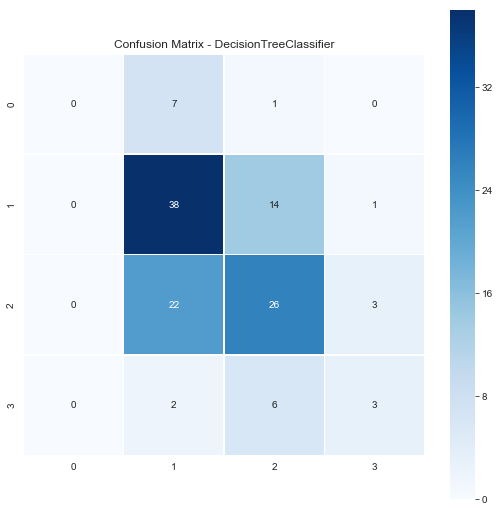

In [46]:
#Score Model
clf_dt = all_in_on_scorer(decision_tree_trainer, X_train, X_test, y_train, y_test)

In [47]:
# Create AdaBoost Instance with Decision Tree Base Classifier
def ada_boost(clf, X_train, y_train):

    abc_dt =AdaBoostClassifier(n_estimators=200, base_estimator=clf, learning_rate=0.015)
    ada_dt = abc_dt.fit(X_train, y_train)
    
    return ada_dt

In [48]:
#Train Model
ada_dt = ada_boost(clf_dt, X_train, y_train)

Model Scores for:  

 ----> AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0005, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.015, n_estimators=200, random_state=None) 

Train Accuracy score:  0.9532520325203252
Test Accuracy score:  0.4715447154471545 

Classification Report:  
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.48      0.53      0.50        53
           2       0.47      0.53      0.50        51
           3       0.60      0.27      0.37        11

   micro avg       0.47      0.47      0.47       123
   macro avg       0.39      0.33      0.34      

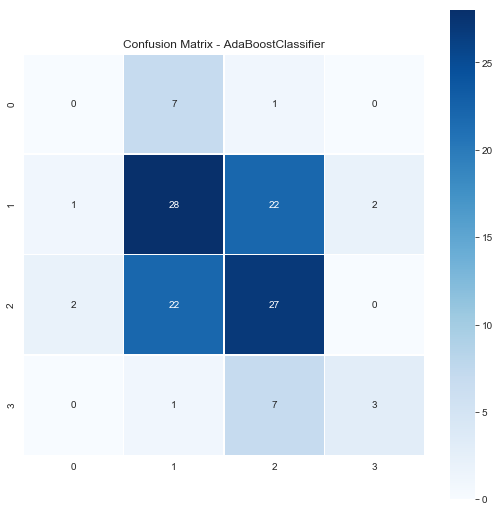

In [49]:
#Score Model
clf_dt_ada = all_in_on_scorer(ada_dt, X_train, X_test, y_train, y_test)

In [50]:
def rfc_model(X_train, y_train):
    
    criterion = 'entropy'
    max_features = 0.8
    n_estimators = 300
    min_samples_leaf = 10
    max_depth = 8
    min_impurity_decrease=0.001
    
    rfc = RandomForestClassifier(criterion=criterion, max_features=max_features, n_estimators=n_estimators, \
                                 min_samples_leaf=min_samples_leaf, min_impurity_decrease=min_impurity_decrease, random_state=1)
    rfc_clf = rfc.fit(X_train, y_train)
    
    return rfc_clf

In [51]:
# Train Model - ROS
rfc_trainer = rfc_model(X_train, y_train)

Model Scores for:  

 ----> RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=0.8, max_leaf_nodes=None,
            min_impurity_decrease=0.001, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False) 

Train Accuracy score:  0.6829268292682927
Test Accuracy score:  0.5365853658536586 

Classification Report:  
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.53      0.53      0.53        53
           2       0.53      0.63      0.58        51
           3       0.60      0.55      0.57        11

   micro avg       0.54      0.54      0.54       123
   macro avg       0.42      0.43      0.42       123
weighted avg       0.50      0.54      0.52       123
 



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


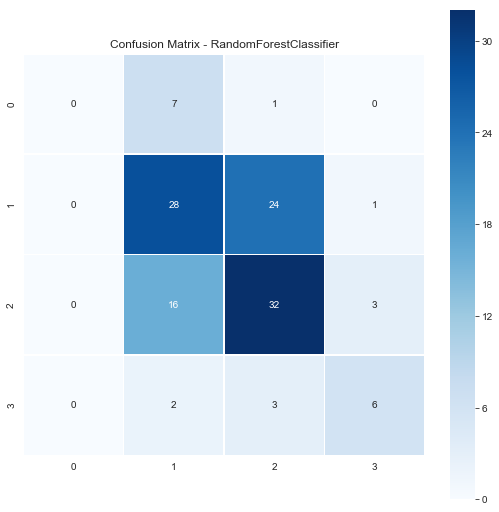

In [52]:
#Score Model
clf_rfc = all_in_on_scorer(rfc_trainer, X_train, X_test, y_train, y_test)

In [53]:
# # Grid Search - RFC
# params = {'criterion' : ['gini', 'entropy'],
#           'max_features' :   [0.35, 0.40, 0.45, 0.50],
#           'n_estimators': [150, 175, 200, 225, 250],
#           'max_depth': [3, 5, 7]
#         }

# rfc_grid = run_grid_search(clf_rfc, params, X_train, y_train)

In [54]:
def xgb_model(X_train, y_train):
    
    objective = 'multi:softprob'
    colsample_bytree = 0.8
    learning_rate = 0.30
    max_depth = 8
    alpha = 5
    n_estimators = 250
    num_class = 4


    xgb_clf = XGBClassifier(objective=objective, colsample_bytree=colsample_bytree, learning_rate=learning_rate, \
                                max_depth=max_depth, alpha=alpha, n_estimators=n_estimators, num_class=4)
    
    xgb_clf = xgb_clf.fit(X_train, y_train)
    
    return xgb_clf

In [55]:
# Train Model
xgb_trainer = xgb_model(X_train, y_train)

Model Scores for:  

 ----> XGBClassifier(alpha=5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=250,
       n_jobs=1, nthread=None, num_class=4, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1) 

Train Accuracy score:  1.0
Test Accuracy score:  0.3821138211382114 

Classification Report:  
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.43      0.42      0.42        53
           2       0.42      0.41      0.42        51
           3       0.29      0.36      0.32        11

   micro avg       0.38      0.38      0.38       123
   macro avg       0.28      0.30      0.29       123
weighted avg       0.39      0.38      0.38       123
 



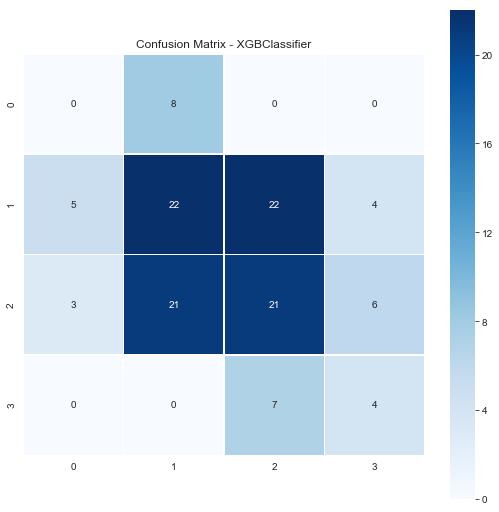

In [56]:
# Convert column names back to original
X_test = X_test[X_train.columns]

# Scoring Function
clf_xgb = all_in_on_scorer(xgb_trainer, X_train, X_test, y_train, y_test)

In [57]:
from sklearn.naive_bayes import MultinomialNB

def nb_model(X_train, y_train):

    nb_clf = MultinomialNB()
    
    nb_clf = nb_clf.fit(X_train, y_train)
    
    return nb_clf

In [58]:
# Train Model
nb_trainer = nb_model(X_train, y_train)

Model Scores for:  

 ----> MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) 

Train Accuracy score:  0.5101626016260162
Test Accuracy score:  0.4796747967479675 

Classification Report:  
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.49      0.49      0.49        53
           2       0.47      0.65      0.55        51
           3       0.00      0.00      0.00        11

   micro avg       0.48      0.48      0.48       123
   macro avg       0.24      0.28      0.26       123
weighted avg       0.41      0.48      0.44       123
 



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


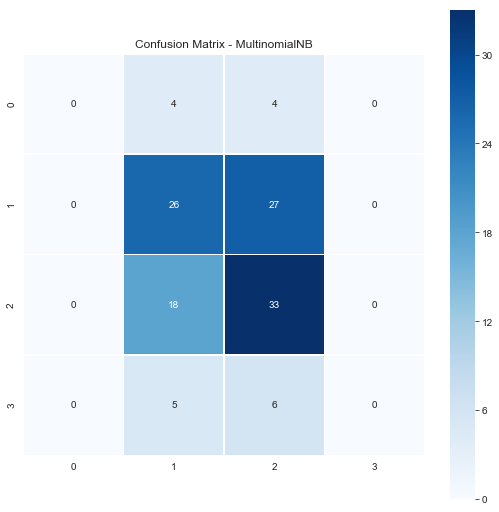

In [59]:
#Score Model
clf_nb = all_in_on_scorer(nb_trainer, X_train, X_test, y_train, y_test)

In [60]:
from sklearn.neighbors import KNeighborsClassifier

def knn_model(X_train, y_train):

    knn_clf = KNeighborsClassifier(n_neighbors=4)
    
    knn_clf = knn_clf.fit(X_train, y_train)
    
    return knn_clf

In [61]:
# Train Model
knn_trainer = knn_model(X_train, y_train)

Model Scores for:  

 ----> KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='uniform') 

Train Accuracy score:  0.5853658536585366
Test Accuracy score:  0.45528455284552843 

Classification Report:  
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.46      0.58      0.52        53
           2       0.55      0.47      0.51        51
           3       0.33      0.09      0.14        11

   micro avg       0.46      0.46      0.46       123
   macro avg       0.34      0.29      0.29       123
weighted avg       0.46      0.46      0.44       123
 



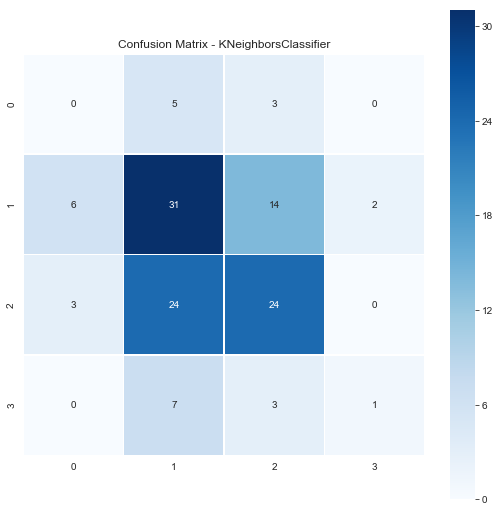

In [62]:
#Score Model
clf_knn = all_in_on_scorer(knn_trainer, X_train, X_test, y_train, y_test)

In [63]:
from sklearn.ensemble import GradientBoostingClassifier

def gbc_model(X_train, y_train):

    gbc_clf = GradientBoostingClassifier(max_features = 0.65, n_estimators=300, learning_rate=1, max_depth=6, random_state=0)
    
    gbc_clf = gbc_clf.fit(X_train, y_train)
    
    return gbc_clf

In [64]:
# Train Model
gbc_trainer = gbc_model(X_train, y_train)

Model Scores for:  

 ----> GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1, loss='deviance', max_depth=6,
              max_features=0.65, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False) 

Train Accuracy score:  1.0
Test Accuracy score:  0.43089430894308944 

Classification Report:  
               precision    recall  f1-score   support

           0       0.20      0.12      0.15         8
           1       0.46      0.49      0.48        53
           2       0.46      0.43      0.44        51
           3       0.29      0.36      0.32        11

   micro avg       0.43      0.43      0.43       123
   macr

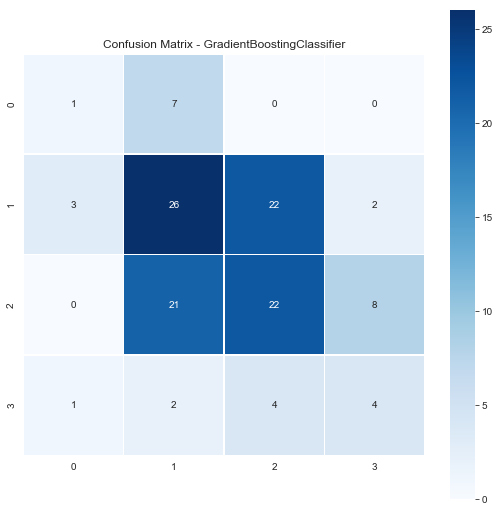

In [65]:
#Score Model
clf_gbc = all_in_on_scorer(gbc_trainer, X_train, X_test, y_train, y_test)